In [1]:
import json
import os
import glob
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
import itertools
import pickle
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_hub as hub

C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: 

In [2]:
root_path = "D:\\MinutesOfMeeting\\meeting-transcript-data\\parsed_data1"

In [3]:
def get_file_content(filename: str) -> json:
    with open(filename) as file_data:
        _data = json.load(file_data)

    return _data

In [4]:
def selected_topics(model, vectorizer, top_n=5):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [5]:
def get_mean_cv_score(k, label, embeddings, pred):
    vectorizers = []

    for ii in range(0, k):
        # Creating a vectorizer
        vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
    vectorized_data = []
    vectorizers = []

    for ii in range(0, k):
        # Creating a vectorizer
        vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
    vectorized_data = []
    for current_cluster, cvec in enumerate(vectorizers):
        try:
            vectorized_data.append(cvec.fit_transform(df.loc[df[label] == current_cluster, 'processed_text']))
        except Exception as e:
            print("Not enough instances in cluster: " + str(current_cluster))
            vectorized_data.append(None)
    lda_models = []
    for ii in range(0, k):
        # Latent Dirichlet Allocation Model
        lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online',verbose=False, random_state=42)
        lda_models.append(lda)

    clusters_lda_data = []
    for current_cluster, lda in enumerate(lda_models):
        # print("Current Cluster: " + str(current_cluster))

        if vectorized_data[current_cluster] != None:
            clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
    
    X_train, X_test, y_train, y_test = train_test_split(embeddings.numpy(), pred, test_size=0.4, random_state=42)

    sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
    # train SGD
    sgd_clf.fit(X_train, y_train)

    sgd_cv_score = cross_val_score(sgd_clf, embeddings.numpy(), pred, cv=10)
    return float(sgd_cv_score.mean()) * 100    

In [6]:
k = 4

In [7]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]
stopwords = list(set(stopwords) | set(custom_stop_words))

In [8]:
parser = spacy.load('en_core_web_sm', disable = ['ner', 'tagger'])
parser.max_length = 7000000

In [9]:
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [10]:
embed = hub.load("D:\\Embeddings\\universal-sentence-encoder_4")

In [11]:
KM_purities = []
GM_purities = []
BR_purities = []
AG_purities = []

In [12]:
for file in os.listdir(root_path):
    file_path = root_path + '\\' + file
    print(file)
    data = get_file_content(file_path)
    df = json_normalize(data,sep="_")
    df["processed_text"] = df["sentence"]
    text = df['processed_text'].values
    
    A = embed(text)
    pca = PCA(n_components=0.95, random_state=42)
    A_reduced= pca.fit_transform(A.numpy())
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
    y_pred_KM = kmeans.fit_predict(A_reduced)
    df['cluster_KMeans'] = y_pred_KM
    KM_purities.append(get_mean_cv_score(k, "cluster_KMeans", A, y_pred_KM))

    gm = GaussianMixture(n_components=k)
    gm = gm.fit(A_reduced)
    y_pred_gm = gm.fit_predict(A_reduced)
    df["cluster_GuassianMixture"] = y_pred_gm
    GM_purities.append(get_mean_cv_score(k, "cluster_GuassianMixture", A, y_pred_gm))

    birch = Birch(n_clusters=k, threshold=0.1)
    y_pred_birch = birch.fit_predict(A_reduced)
    df['cluster_birch'] = y_pred_birch
    BR_purities.append(get_mean_cv_score(k, "cluster_birch", A, y_pred_birch))
    
    agglomerativeClustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    y_pred_agglomerativeClustering = agglomerativeClustering.fit_predict(A_reduced)
    df['cluster_agglomerativeClustering'] = y_pred_agglomerativeClustering
    AG_purities.append(get_mean_cv_score(k, "cluster_agglomerativeClustering", A, y_pred_agglomerativeClustering))


data_meeting_text_pdf_meetingtranscript566.txt
data_meeting_text_pdf_meetingtranscript567.txt
Not enough instances in cluster: 1
Not enough instances in cluster: 2


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 0
Not enough instances in cluster: 3
Not enough instances in cluster: 0
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 2
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


data_meeting_text_pdf_meetingtranscript568.txt
Not enough instances in cluster: 1
Not enough instances in cluster: 3
Not enough instances in cluster: 0
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 2
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 1
Not enough instances in cluster: 2
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


data_meeting_text_pdf_meetingtranscript569.txt
Not enough instances in cluster: 1
Not enough instances in cluster: 3
Not enough instances in cluster: 1
Not enough instances in cluster: 1
data_meeting_text_pdf_meetingtranscript571.txt
Not enough instances in cluster: 1
Not enough instances in cluster: 2
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 1
Not enough instances in cluster: 2
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 0
Not enough instances in cluster: 1
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 0
Not enough instances in cluster: 1
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


data_meeting_text_pdf_meetingtranscript574.txt
Not enough instances in cluster: 3
Not enough instances in cluster: 1
Not enough instances in cluster: 3
data_meeting_text_pdf_meetingtranscript575.txt
data_meeting_text_pdf_meetingtranscript576.txt
Not enough instances in cluster: 3
data_meeting_text_pdf_meetingtranscript578.txt
Not enough instances in cluster: 1
Not enough instances in cluster: 3
data_meeting_text_pdf_meetingtranscript579.txt
Not enough instances in cluster: 2
Not enough instances in cluster: 2
data_meeting_text_pdf_meetingtranscript580.txt
Not enough instances in cluster: 0
Not enough instances in cluster: 2
Not enough instances in cluster: 0
Not enough instances in cluster: 2
Not enough instances in cluster: 1
Not enough instances in cluster: 2
Not enough instances in cluster: 1
Not enough instances in cluster: 3
data_meeting_text_pdf_meetingtranscript581.txt
data_meeting_text_pdf_meetingtranscript582.txt
Not enough instances in cluster: 0
Not enough instances in clust

C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


data_meeting_text_pdf_meetingtranscript583.txt
data_meeting_text_pdf_meetingtranscript584.txt
Not enough instances in cluster: 0
Not enough instances in cluster: 0
Not enough instances in cluster: 3
data_meeting_text_pdf_meetingtranscript585.txt
data_meeting_text_pdf_meetingtranscript587.txt
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


data_meeting_text_pdf_meetingtranscript588.txt
data_meeting_text_pdf_meetingtranscript590.txt
Not enough instances in cluster: 1
Not enough instances in cluster: 2
Not enough instances in cluster: 0
Not enough instances in cluster: 2
Not enough instances in cluster: 1
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 0
Not enough instances in cluster: 1
data_meeting_text_pdf_meetingtranscript592.txt
Not enough instances in cluster: 2
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 0


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 2


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Not enough instances in cluster: 2
Not enough instances in cluster: 3


C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


data_meeting_text_pdf_meetingtranscript594.txt
data_meeting_text_pdf_meetingtranscript595.txt
Not enough instances in cluster: 3
Not enough instances in cluster: 3
Not enough instances in cluster: 2
Not enough instances in cluster: 1
Not enough instances in cluster: 3
data_meeting_text_pdf_meetingtranscript598.txt


In [13]:
KM_purities

[92.84516857354733,
 78.73809523809523,
 84.80952380952381,
 82.56277056277057,
 84.66666666666667,
 95.49999999999999,
 89.57975357975357,
 89.04737139290916,
 95.2548036758563,
 94.22420634920637,
 93.2178932178932,
 92.78309182910702,
 90.94444444444446,
 92.74138904573688,
 89.83816183816185,
 92.59356725146199,
 93.21291208791209,
 93.71894697812382,
 87.28571428571428,
 89.30952380952381,
 93.11375661375662,
 87.84848484848486,
 91.28804513015038]

In [14]:
GM_purities

[93.25038402457757,
 83.0,
 85.77380952380953,
 84.1024531024531,
 82.83333333333334,
 91.1043956043956,
 81.36130536130534,
 87.79474872953135,
 94.01914098972922,
 88.27777777777777,
 94.77777777777779,
 93.06573802541544,
 88.50757575757576,
 92.3478260869565,
 86.04166666666669,
 94.86842105263158,
 88.66666666666667,
 92.55516862170087,
 83.88888888888889,
 83.02380952380952,
 95.7853072853073,
 83.5,
 91.147181884024]

In [15]:
BR_purities

[83.82350760103819,
 88.47619047619048,
 94.66666666666667,
 87.19191919191917,
 82.5,
 94.92307692307692,
 90.60739260739261,
 92.19387401309596,
 86.43925991449211,
 91.14495798319328,
 91.5,
 90.01777499856247,
 90.07070707070707,
 93.06088838697535,
 86.35576923076924,
 92.75386996904025,
 96.55219780219781,
 87.43956247682611,
 91.27777777777779,
 87.47619047619048,
 91.13901169073581,
 81.33366633366632,
 84.86775236775237]

In [16]:
AG_purities

[87.14506418065928,
 93.14285714285715,
 95.83333333333334,
 89.8080808080808,
 82.5,
 94.92307692307692,
 87.05411255411256,
 95.01383399209486,
 90.31185807656395,
 96.81757703081233,
 86.01406926406925,
 93.47599332988328,
 99.0909090909091,
 91.72953133822699,
 92.6771978021978,
 92.75386996904025,
 96.55219780219781,
 84.67955135335558,
 83.97619047619047,
 91.57142857142857,
 89.65710872162485,
 90.23076923076923,
 88.37075537075536]

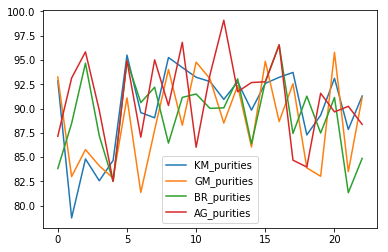

In [17]:
min_purities = min(min(KM_purities), min(GM_purities), min(BR_purities), min(AG_purities))

x = range(int(min_purities), 100)

y1 = np.array(KM_purities)
y2 = np.array(GM_purities) 
y3 = np.array(BR_purities)
y4 = np.array(AG_purities)


# multiple line plot
plt.plot(y1, label = "KM_purities")
plt.plot(y2, label = "GM_purities")
plt.plot(y3, label = "BR_purities")
plt.plot(y4, label = "AG_purities")

# plt.plot(_df['y1'], marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
# plt.plot(_df['y2'], data=_df, marker='', color='olive', linewidth=2)
# plt.plot(_df['y3'], data=_df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
plt.legend()
plt.show()

In [18]:
np.argmax([np.mean(KM_purities), np.mean(GM_purities), np.mean(BR_purities), np.mean(AG_purities)])

3

In [19]:
np.mean(AG_purities)

91.0143202766191